In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
import pandas as pd

In [3]:
from pandas import DataFrame
from IPython.display import HTML
#HTML(DataFrame(MYDATA).to_html())
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
import sys
sys.path.append('/home/maghoi/fastai/old/')

In [5]:
from fastai_v7.imports import *
from fastai_v7.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
set_plot_sizes(12,14,16)

In [6]:
#from fastai.imports import *
#from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from plotnine import *

In [7]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef, average_precision_score
def record_stats(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
            m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)

    #Pairwise comparison
    y_scores = np.array(m.predict(X_valid))
    y_true = np.array(y_valid)
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = y_scores_binary == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    f1 = f1_score(y_true, y_scores_binary, average="binary")
    avp = average_precision_score(y_true, y_scores)

    correct = round(sum(correct) / len(y_true), 3)
    auc = round(auc, 3)
    mcc = round(mcc, 3)
    f1 = round(f1, 3)
    avp = round(avp, 3)

    confusion = metrics.confusion_matrix(y_true, y_scores_binary)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    tpr = round(tpr, 3)
    tnr = round(tnr, 3)
    precision = round(precision, 3)
    recall = round(recall, 3)
    print("Correct", "AUC", "MCC", "F1", "AVP", "TPR", "TNR", "Prec", "Rec", "Confusion")
    return(correct, auc, mcc, f1, avp, tpr, tnr, precision, recall, confusion, y_scores, y_scores_binary, y_true)


In [8]:
!ls main/data

ls: cannot access 'main/data': No such file or directory


In [9]:
df_raw = pd.read_csv("/home/maghoi/main/data/complexes.csv", low_memory=False)
all_energy = pd.read_csv("/home/maghoi/main/data/All_Energy.csv", low_memory = False)

In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
df_raw = df_raw.drop("Unnamed: 0", axis = 1)

In [12]:
#set index to first column then drop it
df_raw = df_raw.set_index(df_raw.iloc[:,0]).drop("key_0", axis = 1)
all_energy = all_energy.set_index(all_energy.iloc[:,0]).drop("Unnamed: 0", axis = 1)

In [13]:
all_energy.rename(columns = {"Unnamed: 0": "key_0"}, inplace = True)

In [14]:
all_energy.index.name = "key_0"
df_raw.index.name = "key_0"

In [15]:
display_all(all_energy.tail(20))

,M_total energy,M_Backbone Hbond,M_Sidechain Hbond,M_Van der Waals,M_Electrostatics,M_Solvation Polar,M_Solvation Hydrophobic,M_Van der Waals clashes,M_entropy sidechain,M_entropy mainchain,M_sloop_entropy,M_mloop_entropy,M_cis_bond,M_torsional clash,M_backbone clash,M_helix dipole,M_water bridge,M_disulfide,M_electrostatic kon,M_partial covalent bonds,M_energy Ionisation,M_Entropy Complex,P_total energy,P_Backbone Hbond,P_Sidechain Hbond,P_Van der Waals,P_Electrostatics,P_Solvation Polar,P_Solvation Hydrophobic,P_Van der Waals clashes,P_entropy sidechain,P_entropy mainchain,P_sloop_entropy,P_mloop_entropy,P_cis_bond,P_torsional clash,P_backbone clash,P_helix dipole,P_water bridge,P_disulfide,P_electrostatic kon,P_partial covalent bonds,P_energy Ionisation,P_Entropy Complex,A_total energy,A_Backbone Hbond,A_Sidechain Hbond,A_Van der Waals,A_Electrostatics,A_Solvation Polar,A_Solvation Hydrophobic,A_Van der Waals clashes,A_entropy sidechain,A_entropy mainchain,A_sloop_entropy,A_mloop_entropy,A_cis_bond,A_torsional clash,A_backbone clash,A_helix dipole,A_water bridge,A_disulfide,A_electrostatic kon,A_partial covalent bonds,A_energy Ionisation,A_Entropy Complex,B_total energy,B_Backbone Hbond,B_Sidechain Hbond,B_Van der Waals,B_Electrostatics,B_Solvation Polar,B_Solvation Hydrophobic,B_Van der Waals clashes,B_entropy sidechain,B_entropy mainchain,B_sloop_entropy,B_mloop_entropy,B_cis_bond,B_torsional clash,B_backbone clash,B_helix dipole,B_water bridge,B_disulfide,B_electrostatic kon,B_partial covalent bonds,B_energy Ionisation,B_Entropy Complex,MP_IntraclashesGroup1,MP_IntraclashesGroup2,MP_Interaction Energy,MP_Backbone Hbond,MP_Sidechain Hbond,MP_Van der Waals,MP_Electrostatics,MP_Solvation Polar,MP_Solvation Hydrophobic,MP_Van der Waals clashes,MP_entropy sidechain,MP_entropy mainchain,MP_sloop_entropy,MP_mloop_entropy,MP_cis_bond,MP_torsional clash,MP_backbone clash,MP_helix dipole,MP_water bridge,MP_disulfide,MP_electrostatic kon,MP_partial covalent bonds,MP_energy Ionisation,MP_Entropy Complex,MP_Number of Residues,MP_Interface Residues,MP_Interface Residues Clashing,MP_Interface Residues VdW Clashing,MP_Interface Residues BB Clashing,MA_IntraclashesGroup1,MA_IntraclashesGroup2,MA_Interaction Energy,MA_Backbone Hbond,MA_Sidechain Hbond,MA_Van der Waals,MA_Electrostatics,MA_Solvation Polar,MA_Solvation Hydrophobic,MA_Van der Waals clashes,MA_entropy sidechain,MA_entropy mainchain,MA_sloop_entropy,MA_mloop_entropy,MA_cis_bond,MA_torsional clash,MA_backbone clash,MA_helix dipole,MA_water bridge,MA_disulfide,MA_electrostatic kon,MA_partial covalent bonds,MA_energy Ionisation,MA_Entropy Complex,MA_Number of Residues,MA_Interface Residues,MA_Interface Residues Clashing,MA_Interface Residues VdW Clashing,MA_Interface Residues BB Clashing,MB_IntraclashesGroup1,MB_IntraclashesGroup2,MB_Interaction Energy,MB_Backbone Hbond,MB_Sidechain Hbond,MB_Van der Waals,MB_Electrostatics,MB_Solvation Polar,MB_Solvation Hydrophobic,MB_Van der Waals clashes,MB_entropy sidechain,MB_entropy mainchain,MB_sloop_entropy,MB_mloop_entropy,MB_cis_bond,MB_torsional clash,MB_backbone clash,MB_helix dipole,MB_water bridge,MB_disulfide,MB_electrostatic kon,MB_partial covalent bonds,MB_energy Ionisation,MB_Entropy Complex,MB_Number of Residues,MB_Interface Residues,MB_Interface Residues Clashing,MB_Interface Residues VdW Clashing,MB_Interface Residues BB Clashing,PA_IntraclashesGroup1,PA_IntraclashesGroup2,PA_Interaction Energy,PA_Backbone Hbond,PA_Sidechain Hbond,PA_Van der Waals,PA_Electrostatics,PA_Solvation Polar,PA_Solvation Hydrophobic,PA_Van der Waals clashes,PA_entropy sidechain,PA_entropy mainchain,PA_sloop_entropy,PA_mloop_entropy,PA_cis_bond,PA_torsional clash,PA_backbone clash,PA_helix dipole,PA_water bridge,PA_disulfide,PA_electrostatic kon,PA_partial covalent bonds,PA_energy Ionisation,PA_Entropy Complex,PA_Number of Residues,PA_Interface Residues,PA_Interface Residues Clashing,PA_Interface Residues VdW Clashing,PA_Interface Residues BB Clashing

### Measuring unique elements in all_identity

In [16]:
df = pd.DataFrame({"1":df_raw.iloc[:,175:200].nunique().index, "2":df_raw.iloc[:,175:200].nunique()})
df = pd.DataFrame({"1":df_raw.nunique().index, "2":df_raw.nunique()})
df = df.drop("y_true", axis = 0)
df.iloc[:,0] = pd.to_numeric(df.iloc[:,0])

In [17]:
df.dtypes

1    int64
2    int64
dtype: object

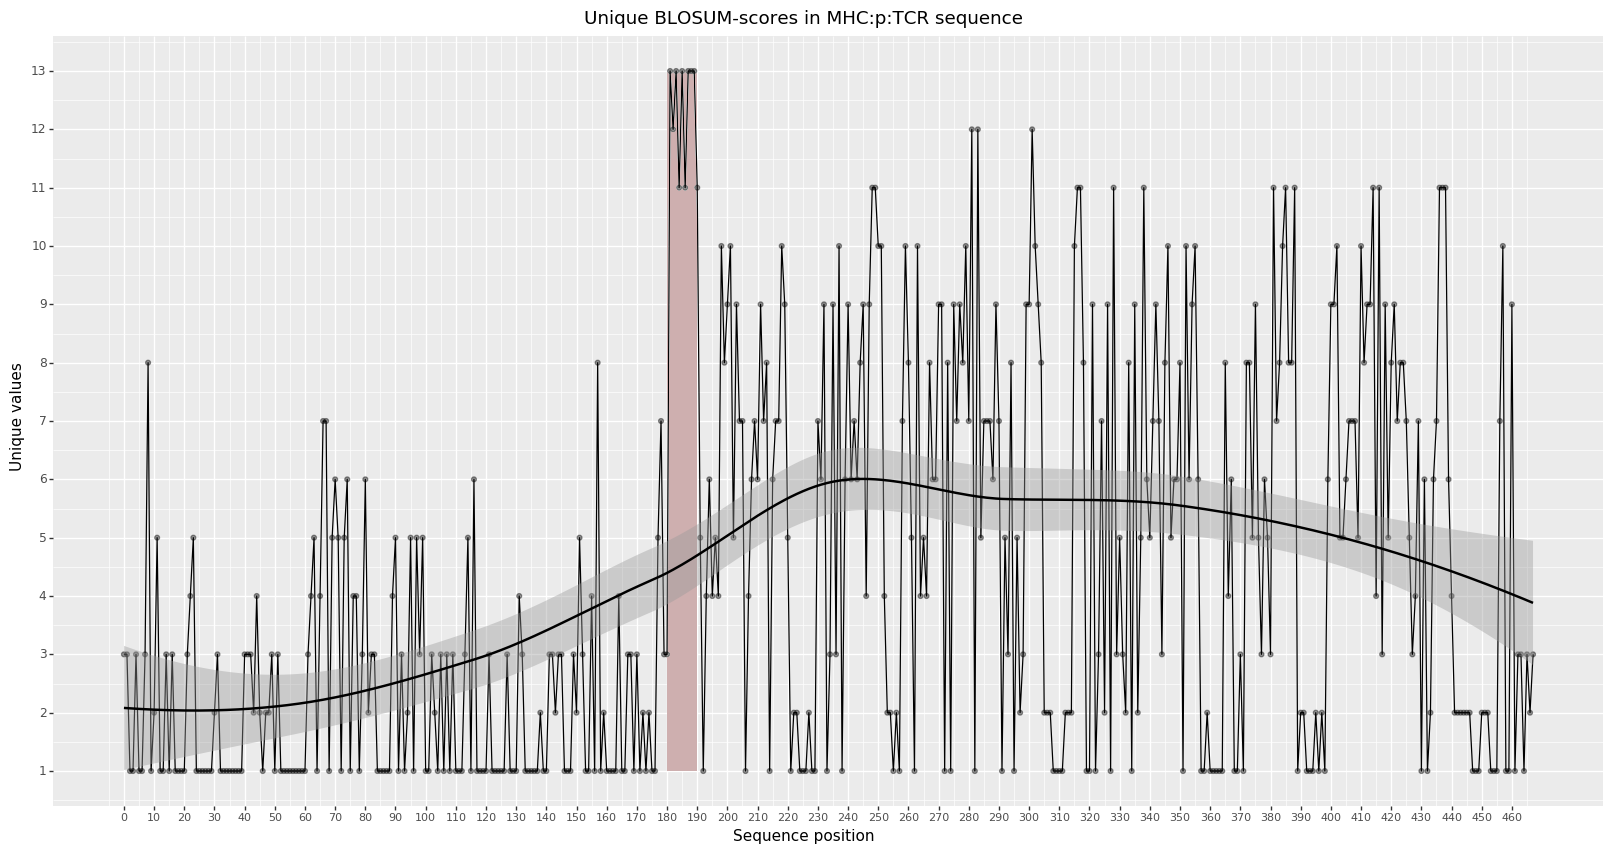

<ggplot: (8772881224575)>

In [2268]:
(ggplot(df, aes("1", "2"))
    + geom_point(alpha = 0.4)
    + scale_x_continuous(breaks=range(0, 467, 10))
    + scale_y_continuous(breaks=range(0, 15, 1))
#    + geom_jitter()
#    + geom_area()
#    + geom_polygon()
    + geom_line()
    + geom_rect(xmin = 180, xmax = 190, ymin = 1, ymax = 13, alpha = 0.002, fill = "#ceafaf")
    + theme(axis_text_x=element_text(size = 8))
    + theme(figure_size =(20,10))
    + stat_smooth(se=True, method='loess')
    + ggtitle("Unique BLOSUM-scores in MHC:p:TCR sequence")
    + xlab("Sequence position")
    + ylab("Unique values")
)

In [2024]:
df = pd.DataFrame({"1":all_energy.nunique().index, "2":all_energy.nunique()})
#df.iloc[:,0] = pd.to_numeric(df.iloc[:,0])
df.dtypes

1    object
2     int64
dtype: object

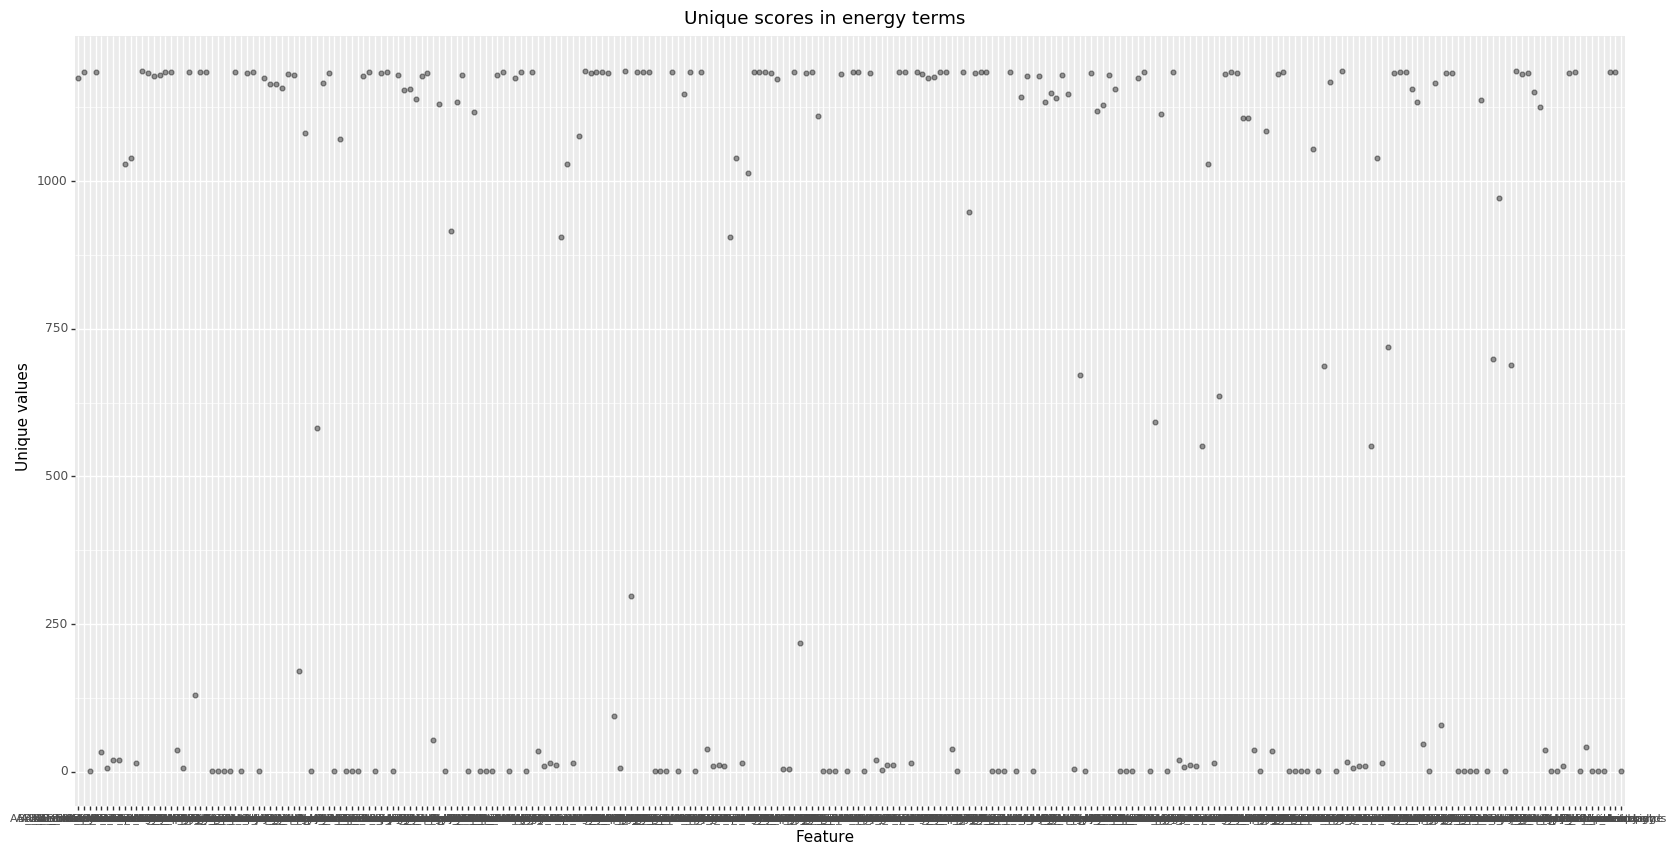

<ggplot: (8772920051418)>

In [2025]:
(ggplot(df, aes("1", "2"))
    + geom_point(alpha = 0.4)
    + geom_line()
    + theme(axis_text_x=element_text(size = 8))
    + theme(figure_size =(20,10))
    + stat_smooth(se=True, method='loess')
    + ggtitle("Unique scores in energy terms")
    + xlab("Feature")
    + ylab("Unique values")
)

# Creating modified datasets with, w/o energy terms, peptide...

In [18]:
# Removing peptide
df_raw_nopep = df_raw.copy() #already contains y_true
df_raw_energy = all_energy.copy() #need to add y_true


#Create column of zeroes (negative complexes)
zeroes = np.zeros((len(df_raw_energy),1))
zeroes = pd.DataFrame(zeroes).set_index(df_raw_energy.index)

#Merge zeroes on the right of complex_df
df = pd.merge(df_raw_energy, zeroes, on = df_raw_energy.index);
df = df.rename(columns={0 : "y_true"})

#Change zero to 1 (true complex) for all true complexes
changes = df[df.iloc[:,0].str.contains("_P")].index
df.loc[changes, "y_true"] = 1

df_raw_energy = df.copy(deep = False)

In [19]:
df_raw_energy = df_raw_energy.set_index(df_raw_energy.key_0).drop("key_0", axis = 1)
df_raw_energy = df_raw_energy.drop(labels = ["M_intface", "A_intface", "B_intface", "P_intface"], axis = 1)

In [20]:
#Merge raw all
df_raw_all = pd.merge(df_raw.drop("y_true", axis = 1), df_raw_energy, on = df_raw.index)

In [21]:
df_raw_all = df_raw_all.set_index(df_raw_all.key_0).drop("key_0", axis = 1)

In [22]:
# Remove peptide blosum scores in df_raw_nopep and raw_all_nopep
df_raw_nopep.iloc[:,181:192] = np.zeros(shape = (1464,11))

#Raw all nopep
df_raw_all_nopep = df_raw_all.copy(deep = False)
#df_raw_all_nopep = df_raw_all_nopep.set_index(df_raw_all_nopep.key_0).drop("key_0", axis = 1)
df_raw_all_nopep.iloc[:,180:191] = np.zeros(shape = (1464,11))

In [23]:
#Convert dataframes to numeric
df_raw_energy = df_raw_energy.apply(pd.to_numeric)
df_raw_all = df_raw_all.apply(pd.to_numeric)
df_raw_all_nopep = df_raw_all_nopep.apply(pd.to_numeric)

In [24]:
#all
remove99 = df_raw[df_raw.index.str.contains("99s")].index
remove95 = df_raw[df_raw.index.str.contains("95s")].index
remove90 = df_raw[df_raw.index.str.contains("90s")].index

#all
df_99 = df_raw
df_95 = df_raw.drop(index = remove99, axis = 0)
df_90 = df_95.drop(index = remove95, axis = 0)
df_80 = df_90.drop(index = remove90, axis = 0)

#nopep
remove99_nopep = df_raw_nopep[df_raw_nopep.index.str.contains("99s")].index
remove95_nopep = df_raw_nopep[df_raw_nopep.index.str.contains("95s")].index
remove90_nopep = df_raw_nopep[df_raw_nopep.index.str.contains("90s")].index

#nopep
df_99_nopep = df_raw_nopep
df_95_nopep = df_raw_nopep.drop(index = remove99_nopep, axis = 0)
df_90_nopep = df_95_nopep.drop(index = remove95_nopep, axis = 0)
df_80_nopep = df_90_nopep.drop(index = remove90_nopep, axis = 0)

#all_energy
remove99_energy = df_raw_energy[df_raw_energy.index.str.contains("99s")].index
remove95_energy = df_raw_energy[df_raw_energy.index.str.contains("95s")].index
remove90_energy = df_raw_energy[df_raw_energy.index.str.contains("90s")].index

#all_energy
df_99_energy = df_raw_energy
df_95_energy = df_raw_energy.drop(index = remove99_energy, axis = 0)
df_90_energy = df_95_energy.drop(index = remove95_energy, axis = 0)
df_80_energy = df_90_energy.drop(index = remove90_energy, axis = 0)

In [25]:
#all combined
remove99_all = df_raw_all[df_raw_all.index.str.contains("99s")].index
remove95_all = df_raw_all[df_raw_all.index.str.contains("95s")].index
remove90_all = df_raw_all[df_raw_all.index.str.contains("90s")].index

#all combined
df_99_all = df_raw_all
df_95_all = df_raw_all.drop(index = remove99_all, axis = 0)
df_90_all = df_95_all.drop(index = remove95_all, axis = 0)
df_80_all = df_90_all.drop(index = remove90_all, axis = 0)

In [26]:
#all_nopep combined
remove99_all_nopep = df_raw_all_nopep[df_raw_all_nopep.index.str.contains("99s")].index
remove95_all_nopep = df_raw_all_nopep[df_raw_all_nopep.index.str.contains("95s")].index
remove90_all_nopep = df_raw_all_nopep[df_raw_all_nopep.index.str.contains("90s")].index

#all_nopep combined
df_99_all_nopep = df_raw_all_nopep
df_95_all_nopep = df_raw_all_nopep.drop(index = remove99_all_nopep, axis = 0)
df_90_all_nopep = df_95_all_nopep.drop(index = remove95_all_nopep, axis = 0)
df_80_all_nopep = df_90_all_nopep.drop(index = remove90_all_nopep, axis = 0)

In [27]:
df_raw.shape, df_95.shape, df_90.shape, df_80.shape

((1464, 469), (1098, 469), (732, 469), (366, 469))

In [28]:
df, y, nas = proc_df(df_99_all, "y_true")

# Statistical testing: importance of peptide

In [29]:
peptide = df_raw.iloc[:, 181:191]

In [30]:
peptide_pos = peptide[peptide.index.str.contains("_P")]
peptide_high = peptide[peptide.index.str.contains("_N")]
peptide_low = peptide[peptide.index.str.contains("_R")]
peptide_switch = peptide[peptide.index.str.contains("_S")]

In [31]:
data = pd.DataFrame({"Pos":peptide_pos.mean(), "High":peptide_high.mean(), "Low":peptide_low.mean(), "Switch":peptide_switch.mean()})
data 


,Pos,High,Low,Switch
181,2.241803,-0.460383,-0.848361,2.069672
182,2.504098,0.941257,3.319672,2.049180
183,2.905738,-0.517760,-0.405738,2.500000
184,2.610656,-1.155738,-0.987705,3.295082
185,3.053279,-1.114754,-1.213115,2.450820
186,3.028689,-0.916667,1.196721,2.938525
187,1.750000,-0.329235,-1.282787,2.184426
188,2.639344,-0.403005,-1.795082,2.684426
189,2.655738,0.280055,0.713115,2.754098
190,-1.045082,-1.729508,-1.885246,-1.061475


In [32]:
peptide_pos = pd.DataFrame(peptide_pos.to_numpy().flatten())
peptide_high = pd.DataFrame(peptide_high.to_numpy().flatten())
peptide_low = pd.DataFrame(peptide_low.to_numpy().flatten())
peptide_switch = pd.DataFrame(peptide_switch.to_numpy().flatten())

##### Mann-Whitney U test comparison of all BLOSUM scores for pos, neg, switch peptides

In [33]:
print("Pos vs switch:", scipy.stats.mannwhitneyu(peptide_pos, peptide_switch))
print("Pos vs high:", scipy.stats.mannwhitneyu(peptide_pos, peptide_high))
print("Pos vs low:", scipy.stats.mannwhitneyu(peptide_pos, peptide_low))

Pos vs switch: MannwhitneyuResult(statistic=2956362.5, pvalue=0.3376120219523998)
Pos vs high: MannwhitneyuResult(statistic=5096378.5, pvalue=4.4217061397069526e-226)
Pos vs low: MannwhitneyuResult(statistic=1815367.0, pvalue=3.8964065606371034e-125)


In [34]:
y_99.shape, y_95.shape, y_90.shape, y_80.shape

NameError: name 'y_99' is not defined

In [ ]:
df_99.shape, df_95.shape, df_90.shape, df_80.shape

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_99, y_99)
m.score(df_99, y_99)

## Split vals

In [ ]:
df, y = df_99, y_99

In [35]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = int(len(df) / 5)  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1172, 730), (1172,), (292, 730))

In [36]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print("1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_")
    print(res)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    
    print("MCC:", metrics.matthews_corrcoef(y_valid, y_hat))
    print("AP:",  metrics.average_precision_score(y_valid, y_hat))
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    print("True positive rate:", tp/(tp+fn))
    print("True negative rate:", tn/(fp+tn))
    print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_hat))
    print("tn, fp, fn, tp")

### Defining lists of dataframes and ys

In [37]:
#Normal dataset
dfs, ys, names = [df_99, df_95, df_90, df_80], [y_99, y_95, y_90, y_80], ["99%", "95%", "90%", "80%"]

#Dataset with peptide "removed" -> set to 0
dfs_nopep, ys_nopep, names_nopep = [df_99_nopep, df_95_nopep, df_90_nopep, df_80_nopep], [y_99_nopep, y_95_nopep, y_90_nopep, y_80_nopep], ["99%", "95%", "90%", "80%"]

#Energy terms
dfs_energy, ys_energy, names_energy = [df_99_energy, df_95_energy, df_90_energy, df_80_energy], [y_99_energy, y_95_energy, y_90_energy, y_80_energy], ["99%", "95%", "90%", "80%"]

#All comb terms
dfs_all, ys_all, names_all = [df_99_all, df_95_all, df_90_all, df_80_all], [y_99_all, y_95_all, y_90_all, y_80_all], ["99%", "95%", "90%", "80%"]

#All nopep terms
dfs_all_nopep, ys_all_nopep, names_all_nopep = [df_99_all_nopep, df_95_all_nopep, df_90_all_nopep, df_80_all_nopep], [y_99_all_nopep, y_95_all_nopep, y_90_all_nopep, y_80_all_nopep], ["99%", "95%", "90%", "80%"]




NameError: name 'y_99' is not defined

#### Tree visualization: Moving y_true value for amino acid blosum scores

In [38]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_
[0.26767951000799456, 0.3610016306276619, 0.48550685627412754, 0.05124742771029667]
MCC: 0.33689457566967096
AP: 0.2866248097412481
True positive rate: 0.3125
True negative rate: 0.9508196721311475
Confusion matrix:
 [[232  12]
 [ 33  15]]
tn, fp, fn, tp


In [39]:
draw_tree(m.estimators_[0], df_trn, precision=3)

NameError: name 'df_trn' is not defined

# 
# Final trees - hyperparameters optimized for MCC / accuracy
# 

In [ ]:
X_train.shape

In [ ]:
dfs, ys, names = [df_99, df_95, df_90, df_80], [y_99, y_95, y_90, y_80], ["99%", "95%", "90%", "80%"]
dfs_nopep, ys_nopep, names_nopep = [df_99_nopep, df_95_nopep, df_90_nopep, df_80_nopep], [y_99_nopep, y_95_nopep, y_90_nopep, y_80_nopep], ["99%", "95%", "90%", "80%"]

###  BLOSUM of complex with peptide
MCC: 0.8615413635611239

In [ ]:
for df, y, name in zip(dfs, ys, names):
    df_trn, y_trn = df, y
    
    n_valid = int(len(df) / 6) # validation = 1/6th of set
    n_trn = len(df)-n_valid
    X_train, X_valid = split_vals(df, n_trn)
    y_train, y_valid = split_vals(y, n_trn)
    print("\nSet:", name)
    print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)
    
    set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)
    
    
    m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)

## Feature importance in complex feature df

### Which sequence positions / amino acids matter (in complex)?

In [40]:
for df, y, name in zip(dfs_all[0:1], ys_all[0:1], names_all[0:1]):
    df = df.drop("y_true", axis = 1)
    df_trn, y_trn = df, y
    
    n_valid = int(len(df) / 6) # validation = 1/6th of set
    n_trn = len(df)-n_valid
    X_train, X_valid = split_vals(df, n_trn)
    y_train, y_valid = split_vals(y, n_trn)
    print("\nSet:", name)
    print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)
    
    set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)
    
    
    m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)
    record_st

NameError: name 'dfs_all' is not defined

### Feature importance per position / amino acid 

In [156]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef, average_precision_score 
def record_stats(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
            m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
        
    #Pairwise comparison
    y_scores = np.array(m.predict(X_valid))
    y_true = np.array(y_valid)
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = y_scores_binary == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    f1 = f1_score(y_true, y_scores_binary, average="binary")
    avp = average_precision_score(y_true, y_scores)

    correct = round(sum(correct) / len(y_true), 3)
    auc = round(auc, 3)
    mcc = round(mcc, 3)
    f1 = round(f1, 3)
    avp = round(avp, 3)

    confusion = metrics.confusion_matrix(y_true, y_scores_binary)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    tpr = round(tpr, 3)
    tnr = round(tnr, 3)
    precision = round(precision, 3)
    recall = round(recall, 3)
    
    return(correct, auc, mcc, f1, avp, tpr, tnr, precision, recall, confusion, y_scores, y_scores_binary, y_true)

In [163]:
dfs, ys, names = [df_raw_all], [y], ["df_raw"]


In [159]:
p0 = df_raw_all.index.str.contains("0p")
p1 = df_raw_all.index.str.contains("1p")
p2 = df_raw_all.index.str.contains("2p")
p3 = df_raw_all.index.str.contains("3p")
p4 = df_raw_all.index.str.contains("4p")


In [162]:
rmse(m.predict(X_valid), y_valid)

0.007130340163116401

In [164]:
partitions = [0, 1, 2, 3, 4]
for df, y, name in zip(dfs, ys, names):
    print(name)
    
    #Cross-val function
    data = [p0, p1, p2, p3, p4]
    partitions = [0, 1, 2, 3, 4]
    run = 0

    values = []
    for i in partitions:
        partitions = [0, 1, 2, 3, 4]
        val_part = data[i]
        partitions.remove(i)

        train_part = [False]*1464
        train_i3 = []
        for i3 in partitions:
            train_part += data[i3]
            train_i3.append(i3)

        train_i3 = "".join(map(str, train_i3))
        run += 1
        print("\nRun", run, "/ 5 ...", "Val", i, "Train", train_i3)

        X_train = df[train_part]
        y_train = y[train_part]

        X_valid = df[val_part]
        y_valid = y[val_part]
        print(X_train.index[0])

        set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        values.append(record_stats(m)[:-3])
        print("Set:", name, "run", i, "of", partitions[-1]+1, values[-1])
        print(record_stats(m)[:-3])

    output = pd.DataFrame(values)
    output.columns = ["Correc", "AUC", "MCC", "F1", "AVP", "TPR", "TNR", "Prec", "Rec", "Confusion"]
    print("\n", name, "\n",output.describe())

    

df_raw

Run 1 / 5 ... Val 0 Train 1234
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 0 of 5 (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, array([[280,   0],
       [  0,  56]]))
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, array([[280,   0],
       [  0,  56]]))

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw run 1 of 5 (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, array([[260,   0],
       [  0,  52]]))
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, array([[260,   0],
       [  0,  52]]))

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 2 of 5 (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, array([[240,   0],
       [  0,  48]]))


KeyboardInterrupt: 

In [109]:
df, y, nas = proc_df(df_99_all, "y_true")


In [111]:
df_trn, y_trn = df, y
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)
m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

print_score(m)

print(record_stats(m)[:-3])

1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_
[0.06116149197095968, 0.2346284993868079, 0.9731400328984051, 0.5992291135397692, 0.8061212473549368]
MCC: 0.7486785993471468
AP: 0.6692351598173516
True positive rate: 0.6041666666666666
True negative rate: 1.0
Confusion matrix:
 [[244   0]
 [ 19  29]]
tn, fp, fn, tp
Correct AUC MCC F1 AVP TPR TNR Prec Rec Confusion
(0.935, 0.952, 0.749, 0.753, 0.86, 0.604, 1.0, 1.0, 0.604, array([[244,   0],
       [ 19,  29]]))


In [112]:
HTML(pd.DataFrame(rf_feat_importance(m, df_trn)).to_html())

,cols,imp
185,185,0.111272
186,186,0.062169
183,183,0.045981
300,300,0.034959
663,PA_electrostatic kon,0.019411
188,188,0.016703
490,P_total energy,0.014477
184,184,0.013923
263,263,0.013558
181,181,0.013342


In [118]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
185,185,0.111272
186,186,0.062169
183,183,0.045981
300,300,0.034959
663,PA_electrostatic kon,0.019411
188,188,0.016703
490,P_total energy,0.014477
184,184,0.013923
263,263,0.013558
181,181,0.013342


In [ ]:
len(fi)

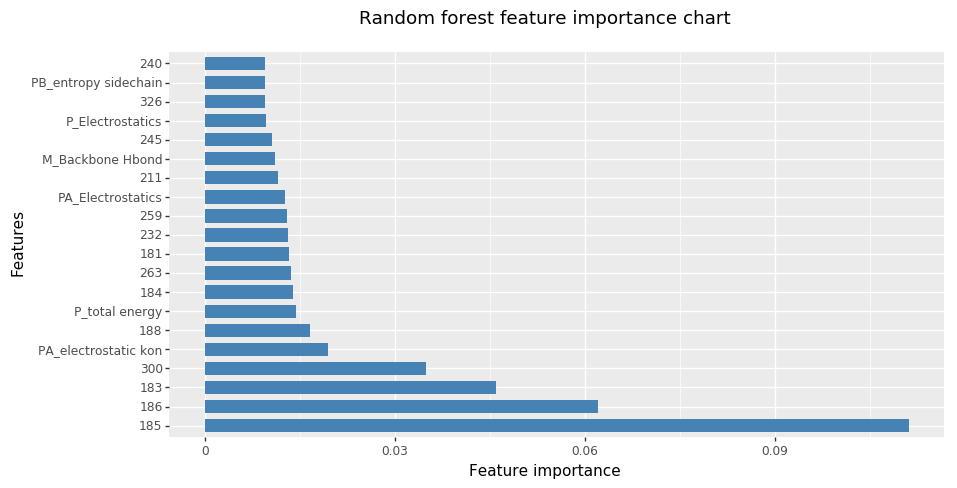

<ggplot: (-9223363250349595399)>

In [136]:
melt_df = fi[0:20].copy()
melt_df["cols"] = pd.Categorical(melt_df["cols"], categories = melt_df["cols"].values, ordered=True)

(ggplot(melt_df, aes("cols", "imp")) #Group together averages
    + geom_bar(stat = "identity", fill = "steelblue", width = 0.7)
    #+ geom_point()
     + coord_flip()
    #+ scale_y_continuous(breaks = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14])
    #+ geom_boxplot(data = melt_df, color = "red", alpha = 0.6, width = 0.8, linetype = "dashed", outlier_alpha = 0.6)
    + ylab("Feature importance")
    + xlab("Features")
    + ggtitle("Random forest feature importance chart\n")
    + theme(figure_size =(10,5))
)

In [121]:
melt_df

,cols,imp
185,185,0.111272
186,186,0.062169
183,183,0.045981
300,300,0.034959
663,PA_electrostatic kon,0.019411
188,188,0.016703
490,P_total energy,0.014477
184,184,0.013923
263,263,0.013558
181,181,0.013342


In [47]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

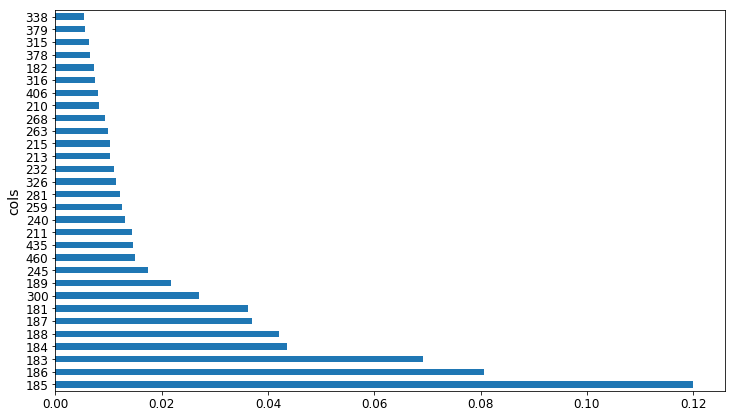

In [48]:
plot_fi(fi[:30]);

### Peptide accounts for 63 % of feature importance with all features

In [49]:
fi[0:10].imp.sum()

0.49500499371174345

In [50]:
print("Number of features that have an importance:")
print(len(fi) - sum(fi.imp == 0))

Number of features that have an importance:
292


In [51]:
to_keep = fi[fi.imp>0.008].cols; len(to_keep)

23

In [52]:
fi[fi.imp>0.008].cols

185    185
186    186
183    183
184    184
188    188
187    187
181    181
300    300
189    189
245    245
460    460
435    435
211    211
240    240
259    259
281    281
326    326
232    232
213    213
215    215
263    263
268    268
210    210
Name: cols, dtype: object

In [53]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

### Removing features and testing accuracy

In [54]:
m = RandomForestRegressor(n_estimators=150, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
print(record_stats(m)[:-3])

1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_
[0.04791480557299818, 0.17752483908780395, 0.9835150059477342, 0.7705685792349726, 0.9415997413070737]
MCC: 0.8184721380883244
AP: 0.7562785388127854
True positive rate: 0.7083333333333334
True negative rate: 1.0
Confusion matrix:
 [[244   0]
 [ 14  34]]
tn, fp, fn, tp
Correct AUC MCC F1 AVP TPR TNR Prec Rec Confusion
(0.952, 0.997, 0.818, 0.829, 0.984, 0.708, 1.0, 1.0, 0.708, array([[244,   0],
       [ 14,  34]]))


### Number of features that have any importance: 234 / 469. Removing features < 0.005 importance -> to 38 reduces accuracy from ca 93 -> 89 %

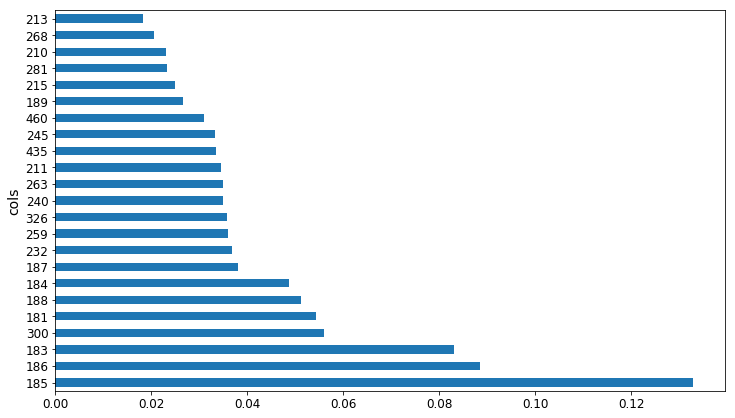

In [55]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:]);

In [176]:
df_keep.shape, df.shape

((1464, 21), (1464, 468))

### Removing co-dependent features?

In [177]:
from scipy.cluster import hierarchy as hc

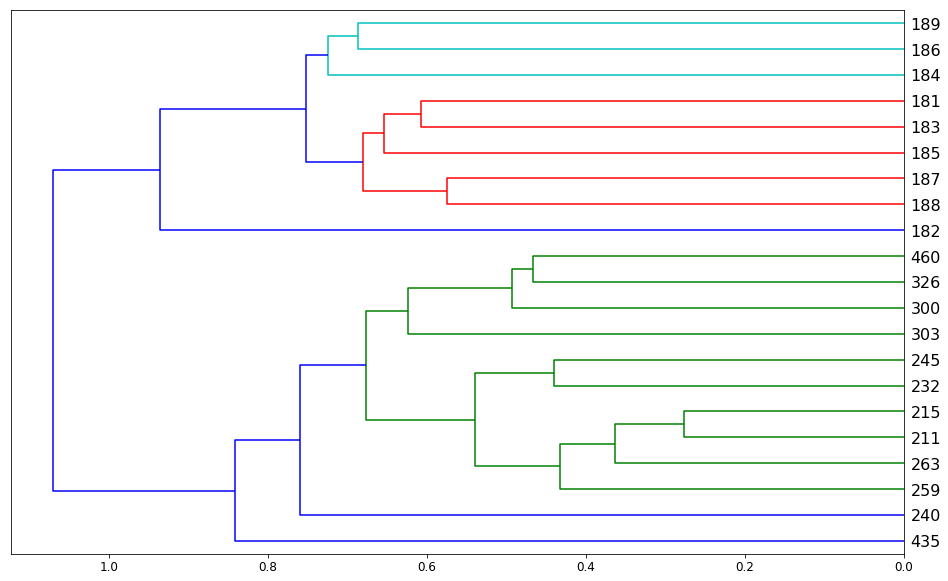

In [178]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [179]:
fi.loc[20]

cols          182
imp     0.0140667
Name: 20, dtype: object

In [180]:
fi = fi.drop([20])

In [181]:
fi.shape

(20, 2)

In [182]:
to_keep = fi.cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

Amino acid do not depend on each other. Thus no need for removal

# 
# Partial dependence
# 

In [56]:
from pdpbox import pdp
from plotnine import *

In [57]:
df_trn2, y_trn = df, y
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=120, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [58]:
x.plot('185', 'y_true', 'scatter', alpha=0.1, figsize=(10,8));

NameError: name 'x' is not defined

In [74]:
from skmisc import *
import sys
sys.path.insert(0, "/usr/local/anaconda3/lib/python3.6/site-packages")

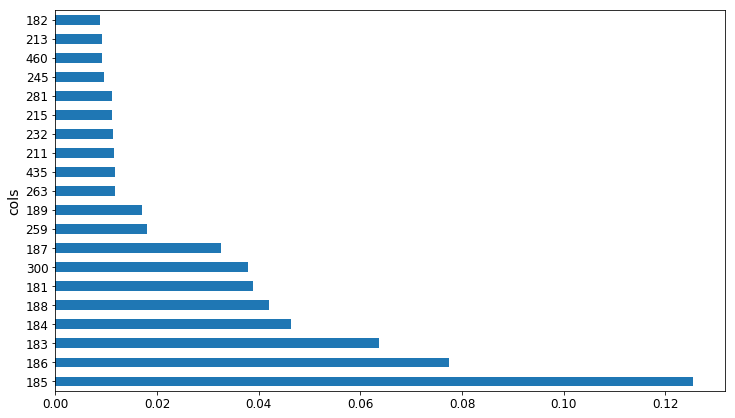

In [75]:
plot_fi(rf_feat_importance(m, df_trn2)[:20]);

In [61]:
str(round(float((fi[fi.loc[:,"cols"].str.contains("PA_electrostatic kon")].imp)), 4))

TypeError: cannot convert the series to <class 'float'>

In [62]:
x_all = get_sample(df_raw_all, 500)

In [ ]:
get_sample()

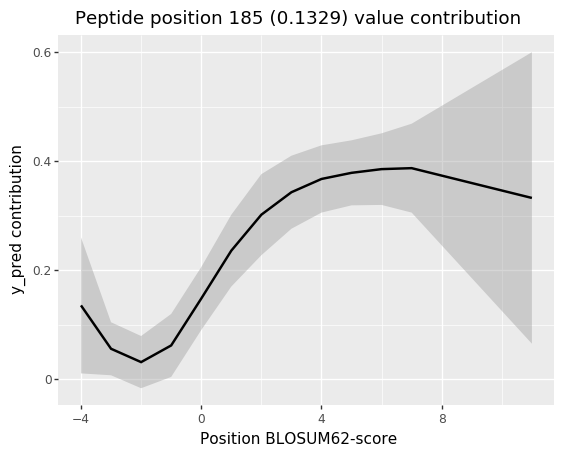

<ggplot: (-9223363250257583514)>

In [63]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("185")].imp)), 4))
(ggplot(x_all, aes("185", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("Peptide position 185 (" + imp + ") value contribution")
    + xlab("Position BLOSUM62-score")
    + ylab("y_pred contribution")
)

In [73]:
df_raw_all.iloc[0:10, 180:190]

,180,181,182,183,184,185,186,187,188,189
key_0,,,,,,,,,,
1g6r_1p_P1_1t_80s_pMHC-TCR,4,1,-1,3,-1,-1,-3,0,2,-4
1g6r_1p_N1_1t_80s_pMHC-TCR,4,-1,-2,0,-1,-1,-2,0,3,-4
1g6r_1p_N2_1t_80s_pMHC-TCR,4,1,0,0,-1,-3,-2,-1,2,-4
1g6r_1p_N3_1t_80s_pMHC-TCR,4,0,4,-1,0,2,-3,-2,2,-4
1g6r_1p_R1_1t_80s_pMHC-TCR,4,0,0,6,-1,0,-1,-1,2,-4
1g6r_1p_S1_1t_80s_pMHC-TCR,4,1,-1,3,-1,-1,-3,0,2,-4
1g6r_1p_P1_1t_90s_pMHC-TCR,4,0,-3,7,2,3,7,0,1,-4
1g6r_1p_N1_1t_90s_pMHC-TCR,4,1,0,-1,2,3,-1,0,4,-4
1g6r_1p_N2_1t_90s_pMHC-TCR,4,0,-1,-1,-2,-3,-2,-1,1,-4


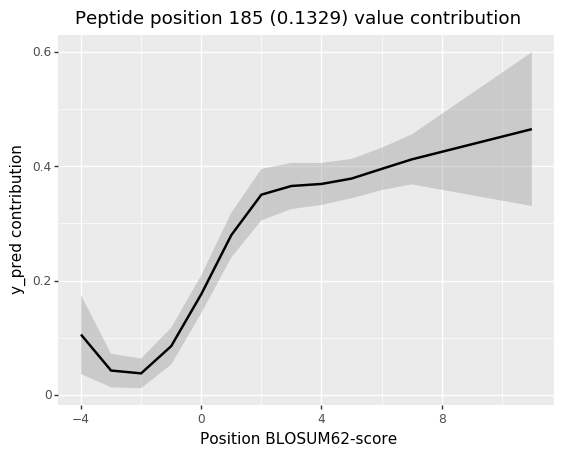

<ggplot: (8786535909384)>

In [65]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("185")].imp)), 4))
(ggplot(df_raw_all, aes("185", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("Peptide position 185 (" + imp + ") value contribution")
    + xlab("Position BLOSUM62-score")
    + ylab("y_pred contribution")
)

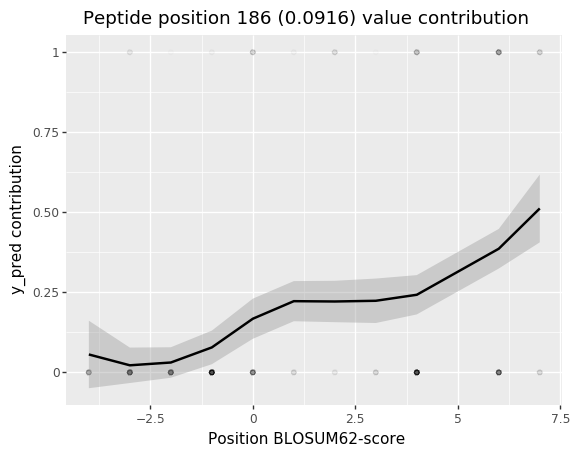

<ggplot: (8759166580095)>

In [227]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("186")].imp)), 4))
(ggplot(x_all, aes("186", 'y_true'))
      + geom_point(alpha = 0.01)
    +stat_smooth(se=True, method='loess')
    + ggtitle("Peptide position 186 (" + imp + ") value contribution")
    + xlab("Position BLOSUM62-score")
    + ylab("y_pred contribution")
)

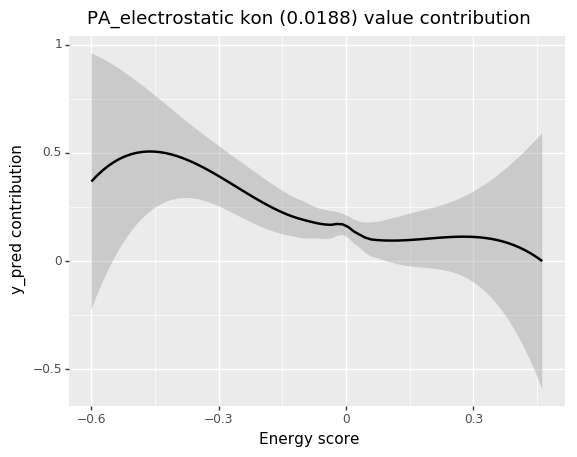

<ggplot: (-9223363277501534867)>

In [94]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("P_total energy")].imp)), 4))
(ggplot(x_all, aes("PA_electrostatic kon", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("PA_electrostatic kon (" + imp + ") value contribution")
    + xlab("Energy score")
    + ylab("y_pred contribution")
)

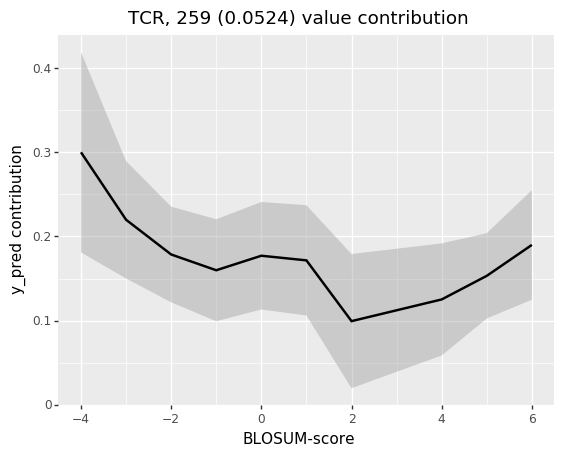

<ggplot: (-9223363263989799743)>

In [2492]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("259")].imp)), 4))
(ggplot(x_all, aes("259", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("TCR, 259 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

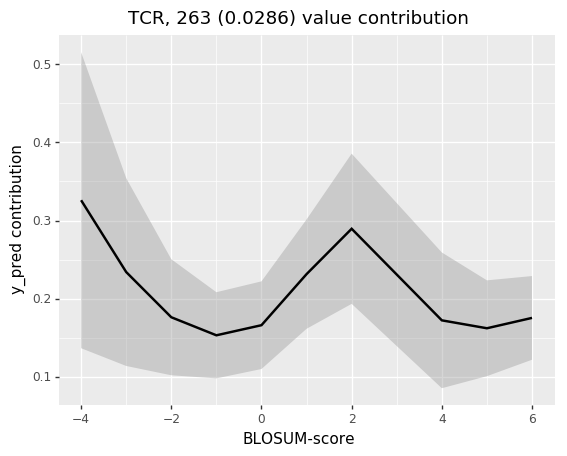

<ggplot: (8759353239479)>

In [95]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("300")].imp)), 4))
(ggplot(x_all, aes("263", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("TCR, 263 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

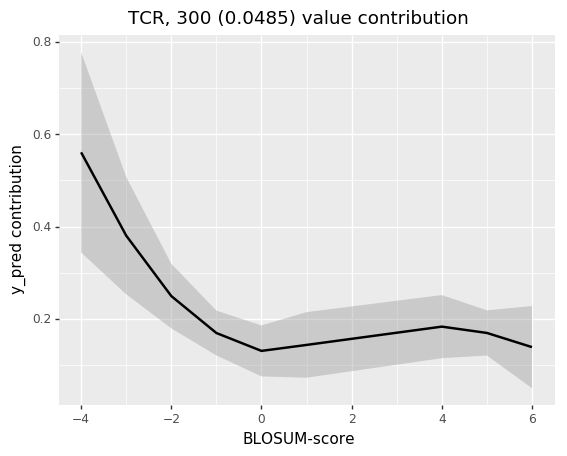

<ggplot: (-9223363263963066073)>

In [2494]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("300")].imp)), 4))
(ggplot(x_all, aes("300", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("TCR, 300 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

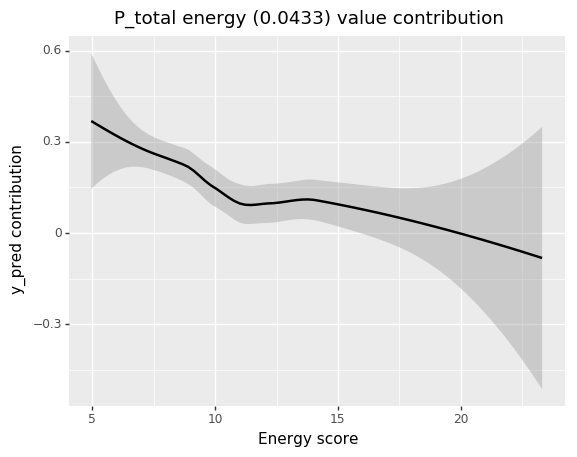

<ggplot: (8772875923306)>

In [2495]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("P_total energy")].imp)), 4))
(ggplot(x_all, aes("P_total energy", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("P_total energy (" + imp + ") value contribution")
    + xlab("Energy score")
    + ylab("y_pred contribution")
)

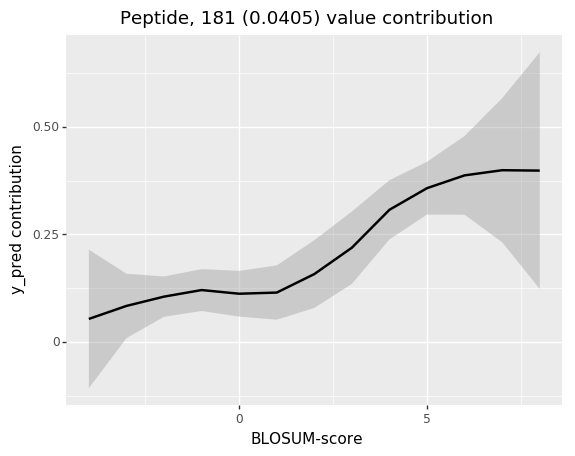

<ggplot: (8772891791901)>

In [2496]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("181")].imp)), 4))
(ggplot(x_all, aes("181", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("Peptide, 181 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

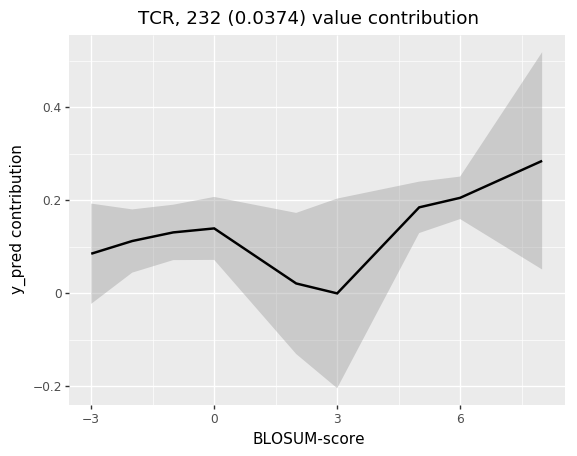

<ggplot: (-9223363263989656309)>

In [2497]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("232")].imp)), 4))
(ggplot(x_all, aes("232", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("TCR, 232 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

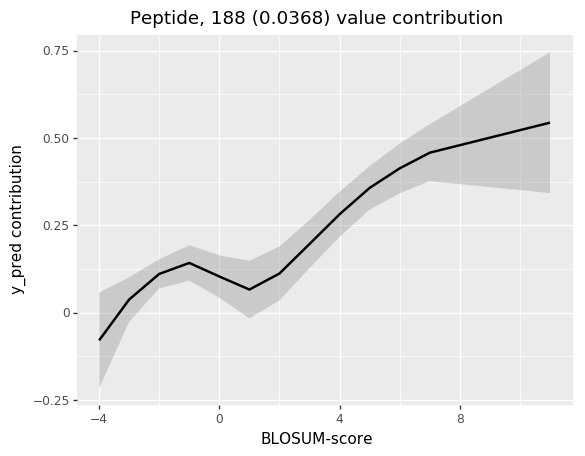

<ggplot: (-9223363263968806368)>

In [2498]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("188")].imp)), 4))
(ggplot(x_all, aes("188", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("Peptide, 188 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

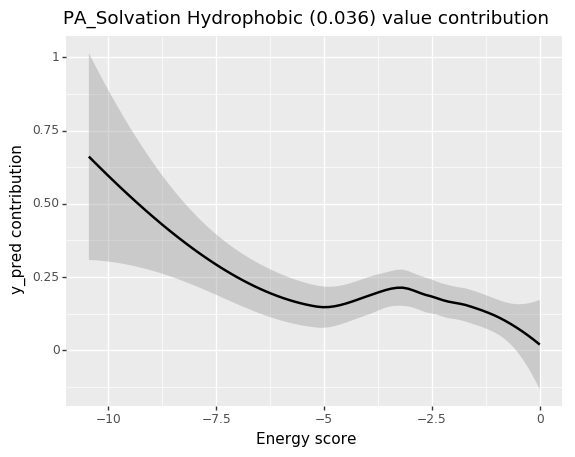

<ggplot: (-9223363263989124485)>

In [2500]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("PA_Solvation Hydrophobic")].imp)), 4))
(ggplot(x_all, aes("PA_Solvation Hydrophobic", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("PA_Solvation Hydrophobic (" + imp + ") value contribution")
    + xlab("Energy score")
    + ylab("y_pred contribution")
)

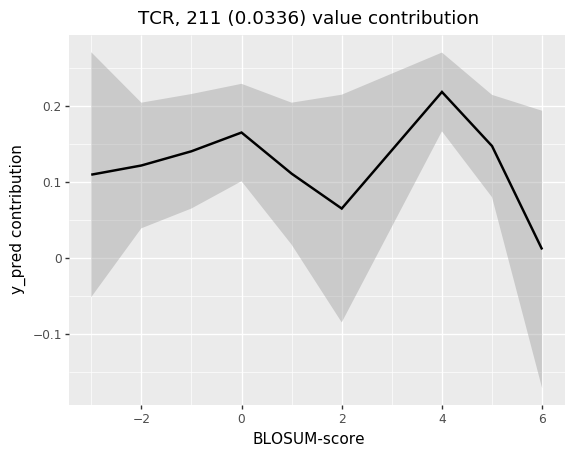

<ggplot: (-9223363263963237621)>

In [2503]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("211")].imp)), 4))
(ggplot(x_all, aes("211", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("TCR, 211 (" + imp + ") value contribution")
    + xlab("BLOSUM-score")
    + ylab("y_pred contribution")
)

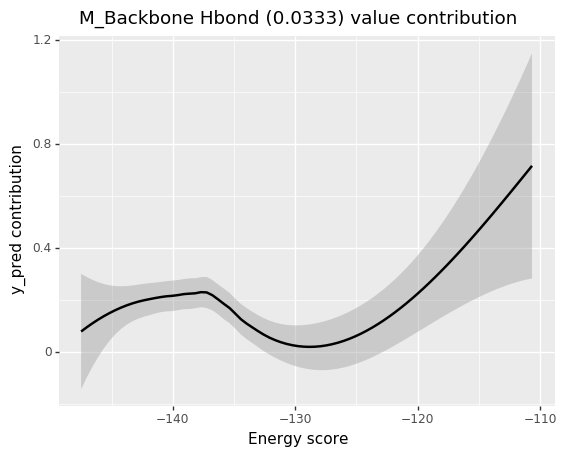

<ggplot: (-9223363263989677596)>

In [2502]:
imp = str(round(float((fi[fi.loc[:,"cols"].str.contains("M_Backbone Hbond")].imp)), 4))
(ggplot(x_all, aes("M_Backbone Hbond", 'y_true'))
    +stat_smooth(se=True, method='loess')
    + ggtitle("M_Backbone Hbond (" + imp + ") value contribution")
    + xlab("Energy score")
    + ylab("y_pred contribution")
)

(500, 469)

In [196]:
x = get_sample(X_train, 500)

In [197]:
pdp.pdp_isolate

<function pdpbox.pdp.pdp_isolate(model, dataset, model_features, feature, num_grid_points=10, grid_type='percentile', percentile_range=None, grid_range=None, cust_grid_points=None, memory_limit=0.5, n_jobs=1, predict_kwds=None, data_transformer=None)>

In [217]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters, figsize = (10,10))

(<Figure size 720x720 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76b0389b38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76b031e668>})

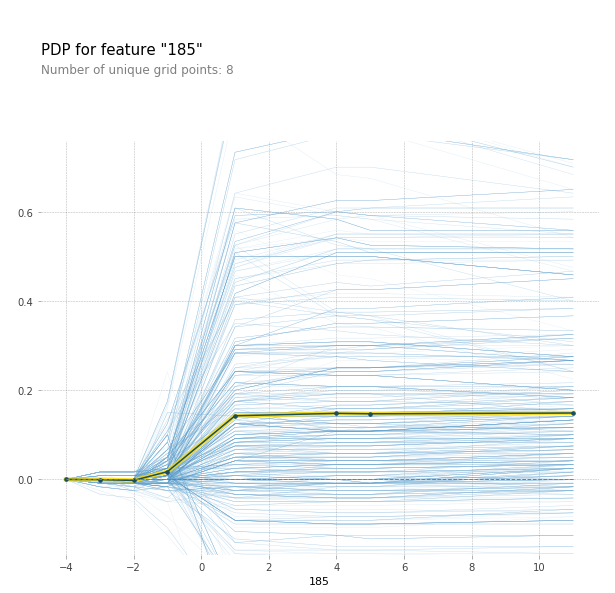

In [218]:
plot_pdp("185")

(<Figure size 720x720 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76b03c6710>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76f40f0438>})

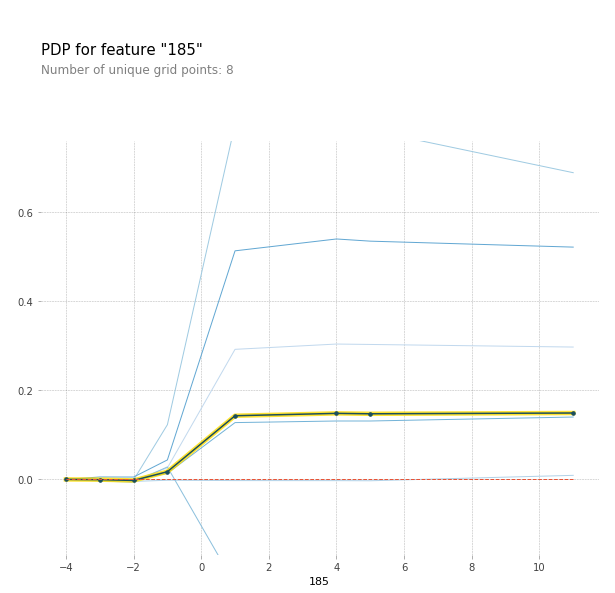

In [219]:
plot_pdp('185', clusters=6)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76f41ae080>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76705a6128>})

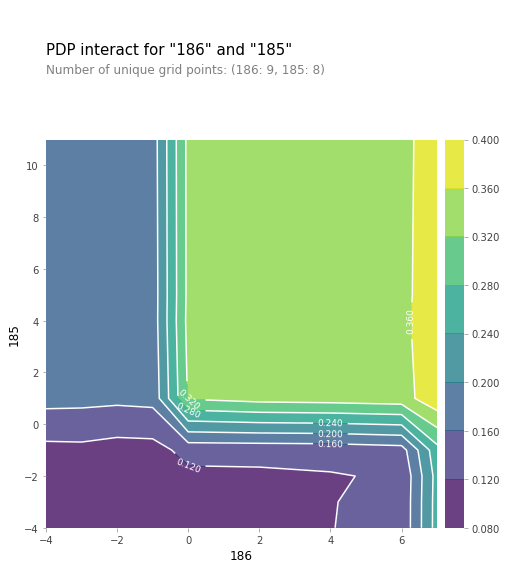

In [220]:
feats = ['186', '185']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

### Tree interpreter

In [1809]:
df_keep.shape

(1464, 36)

1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_
[0.036545222378424884, 0.21987302802238018, 0.9904091520958779, 0.647277301198257]
MCC: 0.6900048724234678
AP: 0.598672131147541
True positive rate: 0.575
True negative rate: 0.9901960784313726
Confusion matrix:
 [[202   2]
 [ 17  23]]
tn, fp, fn, tp


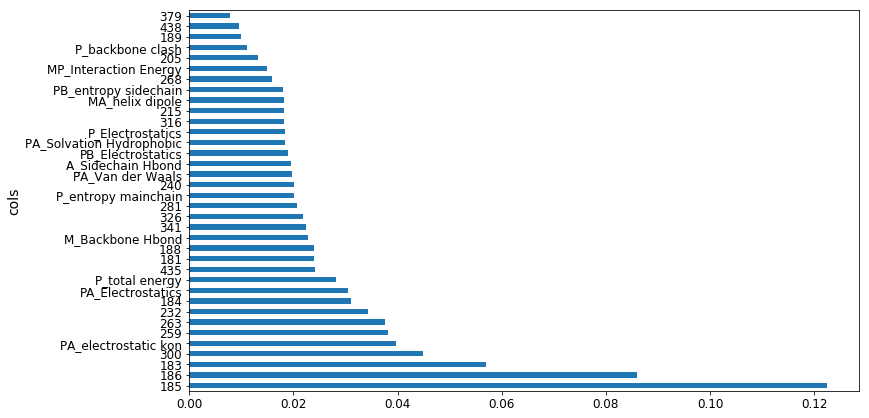

In [1807]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=120, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)
plot_fi(rf_feat_importance(m, df_keep));

In [1477]:
from treeinterpreter import treeinterpreter as ti

In [1481]:
df_raw_all

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,y_true
key_0,,,,,,,,,,,,,,,,,,,,,
1g6r_1p_P1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,1.0
1g6r_1p_N1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,0.0
1g6r_1p_N2_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,0.0
1g6r_1p_N3_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,0.0
1g6r_1p_R1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,0.0
1g6r_1p_S1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,-1,6,1,5,4,1,4,4,0.0
1g6r_1p_P1_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,4,6,5,5,4,4,4,4,1.0
1g6r_1p_N1_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,4,6,5,5,4,4,4,4,0.0
1g6r_1p_N2_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,4,6,5,5,4,4,4,4,0.0


In [1482]:
df_train, df_valid = split_vals(df_raw_all[df_keep.columns], n_trn)

In [1556]:
y_valid

key_0
5c0c_1p_N2_1t_99s_pMHC-TCR    0.0
5c0c_1p_N3_1t_99s_pMHC-TCR    0.0
5c0c_1p_R1_1t_99s_pMHC-TCR    0.0
5c0c_1p_S1_1t_99s_pMHC-TCR    0.0
5c07_1p_P1_1t_80s_pMHC-TCR    1.0
5c07_1p_N1_1t_80s_pMHC-TCR    0.0
5c07_1p_N2_1t_80s_pMHC-TCR    0.0
5c07_1p_N3_1t_80s_pMHC-TCR    0.0
5c07_1p_R1_1t_80s_pMHC-TCR    0.0
5c07_1p_S1_1t_80s_pMHC-TCR    0.0
5c07_1p_P1_1t_90s_pMHC-TCR    1.0
5c07_1p_N1_1t_90s_pMHC-TCR    0.0
5c07_1p_N2_1t_90s_pMHC-TCR    0.0
5c07_1p_N3_1t_90s_pMHC-TCR    0.0
5c07_1p_R1_1t_90s_pMHC-TCR    0.0
5c07_1p_S1_1t_90s_pMHC-TCR    0.0
5c07_1p_P1_1t_95s_pMHC-TCR    1.0
5c07_1p_N1_1t_95s_pMHC-TCR    0.0
5c07_1p_N2_1t_95s_pMHC-TCR    0.0
5c07_1p_N3_1t_95s_pMHC-TCR    0.0
5c07_1p_R1_1t_95s_pMHC-TCR    0.0
5c07_1p_S1_1t_95s_pMHC-TCR    0.0
5c07_1p_P1_1t_99s_pMHC-TCR    1.0
5c07_1p_N1_1t_99s_pMHC-TCR    0.0
5c07_1p_N2_1t_99s_pMHC-TCR    0.0
5c07_1p_N3_1t_99s_pMHC-TCR    0.0
5c07_1p_R1_1t_99s_pMHC-TCR    0.0
5c07_1p_S1_1t_99s_pMHC-TCR    0.0
5c08_1p_P1_1t_80s_pMHC-TCR    1.0
5c08_1p_

In [1517]:
y_valid.values

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1.

In [1555]:
row = X_valid.values[None,10]; row
prediction, bias, contributions = ti.predict(m, row)
print("Prediction: ", prediction[0], " Start bias: ", bias[0])
print("Total contribution", contributions[0].sum())
print("\nAll contributing terms:")
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], np.around(contributions[0][idxs], 5))]

Prediction:  [0.975]  Start bias:  0.16667805100182148
Total contribution 0.8083219489981784

All contributing terms:


[('181', -1.0, -0.02842),
 ('P_Electrostatics', -0.0742825, -0.0085),
 ('188', -2.0, -0.00742),
 ('189', 0.0, -0.00464),
 ('326', 4.0, -0.00182),
 ('M_Backbone Hbond', -132.38, -0.0005),
 ('MA_helix dipole', -0.029689499999999997, 0.00016),
 ('379', 4.0, 0.00073),
 ('A_Sidechain Hbond', -25.7646, 0.00143),
 ('P_backbone clash', 0.798953, 0.0015),
 ('P_entropy mainchain', 7.17742, 0.00167),
 ('P_total energy', 8.67419, 0.0017),
 ('PA_Solvation Hydrophobic', -2.0893900000000003, 0.002),
 ('PB_Electrostatics', -0.126906, 0.00329),
 ('MP_Interaction Energy', -3.7876199999999995, 0.00424),
 ('PA_Van der Waals', -1.92143, 0.00594),
 ('PB_entropy sidechain', 4.51627, 0.00596),
 ('341', 5.0, 0.00749),
 ('205', 7.0, 0.0085),
 ('435', 4.0, 0.00895),
 ('240', 5.0, 0.0101),
 ('316', 5.0, 0.0144),
 ('268', 5.0, 0.01894),
 ('PA_Electrostatics', 0.320389, 0.02043),
 ('438', 5.0, 0.02432),
 ('PA_electrostatic kon', 0.034382199999999995, 0.02777),
 ('259', 6.0, 0.028),
 ('215', 5.0, 0.03113),
 ('184', 

In [1554]:
row = X_valid.values[None,0]; row
prediction, bias, contributions = ti.predict(m, row)
print("Prediction: ", prediction[0], " Start bias: ", bias[0])
print("Total contribution", contributions[0].sum())
print("\nAll contributing terms:")
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], np.around(contributions[0][idxs], 5))]

Prediction:  [0.]  Start bias:  0.16667805100182148
Total contribution -0.16667805100182145

All contributing terms:


[('185', -1.0, -0.04835),
 ('183', 0.0, -0.03276),
 ('186', -3.0, -0.0127),
 ('181', -1.0, -0.01004),
 ('326', 4.0, -0.00999),
 ('P_total energy', 8.67419, -0.00928),
 ('184', -1.0, -0.00798),
 ('188', -2.0, -0.00614),
 ('P_entropy mainchain', 7.17742, -0.00532),
 ('M_Backbone Hbond', -132.38, -0.00422),
 ('PA_electrostatic kon', 0.034382199999999995, -0.0033),
 ('341', 5.0, -0.00299),
 ('263', 6.0, -0.00227),
 ('A_Sidechain Hbond', -25.7646, -0.00204),
 ('435', 4.0, -0.00162),
 ('P_backbone clash', 0.798953, -0.0016),
 ('MA_helix dipole', -0.029689499999999997, -0.0015),
 ('PA_Solvation Hydrophobic', -2.0893900000000003, -0.00126),
 ('205', 7.0, -0.00073),
 ('PA_Van der Waals', -1.92143, -0.0004),
 ('316', 5.0, -0.00039),
 ('PA_Electrostatics', 0.320389, -0.00033),
 ('PB_entropy sidechain', 4.51627, -0.00032),
 ('PB_Electrostatics', -0.126906, -0.00025),
 ('281', 4.0, -0.00021),
 ('240', 5.0, -0.0002),
 ('MP_Interaction Energy', -3.7876199999999995, -0.00011),
 ('232', 5.0, -0.0001),


In [1563]:
df_keep.columns

Index(['185', '186', '183', '300', 'PA_electrostatic kon', '259', '184', '263',
       '181', '232', 'PA_Electrostatics', 'P_total energy', '215', '188',
       '281', '268', 'M_Backbone Hbond', '435', '326', 'P_entropy mainchain',
       '341', 'PA_Solvation Hydrophobic', '240', 'PB_Electrostatics', '316',
       'A_Sidechain Hbond', 'PB_entropy sidechain', 'PA_Van der Waals',
       'MP_Interaction Energy', 'P_Electrostatics', '205', '189',
       'MA_helix dipole', 'P_backbone clash', '379', '438'],
      dtype='object')

# 
# Plotting contributions
# 

#### Negative and positive complex generation:
- N = Negative with high % identity peptide
- R = Negative with low rank % identity peptide
- S = Negative with same peptide, switched TCR
- P = Positive complex

In [1705]:
df_valid

,185,186,183,300,PA_electrostatic kon,259,184,263,181,232,...,PB_entropy sidechain,PA_Van der Waals,MP_Interaction Energy,P_Electrostatics,205,189,MA_helix dipole,P_backbone clash,379,438
key_0,,,,,,,,,,,,,,,,,,,,,
5c0c_1p_N2_1t_99s_pMHC-TCR,-1,-3,0,5,0.034382,6,-1,6,-1,5,...,4.516270,-1.921430,-3.78762,-0.074283,7,0,-0.029689,0.798953,4,5
5c0c_1p_N3_1t_99s_pMHC-TCR,-1,-1,6,5,-0.020810,6,-3,6,2,5,...,3.360420,-3.864910,-12.79680,-0.338248,7,-1,-0.157340,0.861388,4,5
5c0c_1p_R1_1t_99s_pMHC-TCR,-1,6,-3,5,-0.097130,6,-3,6,-1,5,...,4.809870,-3.205260,-11.25830,-0.207983,7,7,0.053413,2.843130,4,5
5c0c_1p_S1_1t_99s_pMHC-TCR,7,6,6,-1,0.055961,-3,6,-1,5,0,...,0.357264,-3.108840,-12.69130,0.029049,-1,0,-0.027189,2.200540,4,-2
5c07_1p_P1_1t_80s_pMHC-TCR,-3,-1,-2,0,-0.101645,1,6,6,-2,0,...,1.541680,-2.886550,-14.95790,0.317371,7,-1,-0.066962,2.082550,4,-4
5c07_1p_N1_1t_80s_pMHC-TCR,-3,-4,-2,0,0.144431,1,-2,6,2,0,...,0.689307,-2.843580,-14.12790,0.106945,7,-1,-0.114727,2.702910,4,-4
5c07_1p_N2_1t_80s_pMHC-TCR,-3,-2,-1,0,-0.021204,1,0,6,-2,0,...,0.999022,-1.820090,-18.41200,0.102776,7,-1,-0.103068,3.471960,4,-4
5c07_1p_N3_1t_80s_pMHC-TCR,2,6,-2,0,-0.201444,1,-2,6,0,0,...,2.031700,-2.318100,-13.98350,-0.189720,7,-1,-0.098298,1.864060,4,-4
5c07_1p_R1_1t_80s_pMHC-TCR,-3,-1,1,0,0.003095,1,-3,6,-1,0,...,1.847770,-2.782400,-7.51466,-0.115041,7,-2,-0.088076,2.554310,4,-4


In [1814]:
row = X_valid.values[None,0]; row
prediction, bias, contributions = ti.predict(m, row)
print("Prediction: ", prediction[0], " Start bias: ", bias[0])
print("Total contribution", contributions[0].sum())
print("\nAll contributing terms:")
a = pd.DataFrame([o for o in zip(df_keep.columns, df_valid.iloc[0], np.around(contributions[0], 5))])

Prediction:  [0.]  Start bias:  0.16873861566484516
Total contribution -0.16873861566484516

All contributing terms:


In [1666]:
row = X_valid.values[None,0]; row
prediction, bias, contributions = ti.predict(m, row)
a = pd.DataFrame([o for o in zip(df_keep.columns, np.around(contributions[0], 5))])

In [1667]:
a = a.rename(columns={0: "feature", 1: "0"})

In [ ]:
a = pd.DataFrame(a[0])

In [1669]:
for i in range(1, 5):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    a[str(i)] = b

# Average contribution chart:
### Creating averages for all pos, high %ID, low %ID, switch TCR groups

In [1947]:
df_pos = pd.DataFrame(df_keep.columns)
df_low = pd.DataFrame(df_keep.columns)
df_high = pd.DataFrame(df_keep.columns)
df_switch = pd.DataFrame(df_keep.columns)

In [1948]:
#get positives
df_pos = pd.DataFrame(df_keep.columns)

for i in range(4, 244, 6):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    df_pos[str(i)] = b

In [1949]:
#get switch TCR
df_switch = pd.DataFrame(df_keep.columns)

for i in range(3, 244, 6):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    df_switch[str(i)] = b

In [1950]:
#get low ID
df_low = pd.DataFrame(df_keep.columns)

for i in range(2, 244, 6):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    df_low[str(i)] = b

In [1951]:
#get high ID first time
df_high = pd.DataFrame(df_keep.columns)

for i in range(1, 244, 6):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    df_high[str(i)] = b

In [1952]:
#get high ID second time
#df_high = pd.DataFrame(df_keep.columns)

for i in range(0, 244, 6):
    row = X_valid.values[None,i];
    prediction, bias, contributions = ti.predict(m, row)
    b = pd.DataFrame(np.around(contributions[0], 5))
    df_high[str(i)] = b

In [1954]:
df_pos = df_pos.set_index(df_pos.iloc[:,0]).drop(0, axis = 1)
df_high = df_high.set_index(df_high.iloc[:,0]).drop(0, axis = 1)
df_low = df_low.set_index(df_low.iloc[:,0]).drop(0, axis = 1)
df_switch = df_switch.set_index(df_switch.iloc[:,0]).drop(0, axis = 1)
df_high

,1,7,13,19,25,31,37,43,49,55,...,186,192,198,204,210,216,222,228,234,240
0,,,,,,,,,,,,,,,,,,,,,
185,-0.06453,0.14791,-0.06707,-0.06707,-0.06707,0.09831,-0.07421,-0.07358,-0.07358,-0.06344,...,-0.07388,-0.07388,-0.07557,-0.07557,0.14263,-0.07028,-0.12981,-0.12806,-0.13256,-0.06588
186,-0.07503,0.11407,-0.01191,-0.01191,-0.01191,-0.10122,0.01181,0.00604,0.00604,-0.01439,...,0.00240,0.00239,-0.04037,-0.04037,0.00651,0.00531,-0.01231,-0.01231,-0.01224,-0.01347
183,0.03796,-0.10697,-0.02220,-0.02220,-0.02220,-0.10676,-0.03355,-0.03698,-0.03619,-0.02220,...,-0.02942,-0.02942,0.03613,0.03613,-0.11139,-0.02942,-0.02265,-0.02306,-0.02306,-0.02654
300,-0.00026,-0.03550,0.00000,0.00000,-0.00007,0.10095,-0.00024,-0.00024,-0.00024,-0.00008,...,-0.00041,-0.00034,-0.00105,-0.00105,-0.03273,-0.00034,0.00396,-0.00021,-0.00014,0.00213
PA_electrostatic kon,-0.00266,0.07748,0.00877,0.00877,-0.00256,0.01748,0.00911,0.07359,0.07155,-0.00263,...,-0.01520,-0.00320,-0.00402,-0.00402,-0.03768,-0.00424,0.01343,0.00758,0.00855,-0.00345
259,-0.00121,-0.01842,0.00000,0.00000,0.00000,-0.01209,0.00314,0.00314,0.00314,0.00000,...,-0.00052,-0.00036,-0.00236,-0.00236,-0.02507,-0.00036,0.00000,0.00000,0.00000,0.00000
184,-0.02960,-0.02410,-0.01288,-0.01288,-0.01115,0.01774,-0.01156,-0.01610,-0.01059,-0.01229,...,-0.00982,-0.00945,-0.01444,-0.01457,-0.03433,-0.01533,-0.00328,-0.00057,0.00018,-0.01625
263,0.00806,0.04133,-0.00220,-0.00220,-0.00223,-0.01178,-0.00091,0.00249,0.00247,-0.00221,...,-0.00278,-0.00868,-0.00491,-0.00491,0.02321,-0.00160,-0.00266,-0.00189,-0.00186,0.00037
181,-0.00306,-0.01164,-0.00618,-0.00618,-0.00618,0.04418,0.02449,0.03142,0.03142,-0.00641,...,-0.00686,-0.00686,-0.00597,-0.00597,-0.02766,-0.00686,-0.00190,-0.00190,-0.00190,-0.00618


In [ ]:
df_pos.shape, df_switch.shape, df_low.shape, df_high.shape

#### Box chart?

In [1971]:
df_posm = pd.DataFrame(df_pos.mean(axis = 1))
df_highm = pd.DataFrame(df_high.mean(axis = 1))
df_lowm = pd.DataFrame(df_low.mean(axis = 1))
df_switchm = pd.DataFrame(df_switch.mean(axis = 1))
df_posm

,0
0,
185,8.065825e-02
186,5.117875e-02
183,-6.078000e-03
300,1.960375e-02
PA_electrostatic kon,7.815250e-03
259,7.353000e-03
184,3.616675e-02
263,2.802225e-02
181,1.338100e-02


In [1913]:
#df_posm = df_posm.reset_index().drop("index", axis = 1)
#df_highm = df_highm.reset_index().drop("index", axis = 1)
#df_lowm = df_lowm.reset_index().drop("index", axis = 1)
#df_switchm = df_switchm.reset_index().drop("index", axis = 1)

In [1974]:
df = pd.DataFrame({"Positive" : df_posm[0], "High ID" : df_highm[0], "Low ID" : df_lowm[0], "TCR switch" : df_switchm[0]})
df


,Positive,High ID,Low ID,TCR switch
0,,,,
185,8.065825e-02,-0.042211,-0.074436,0.035306
186,5.117875e-02,-0.010518,-0.004994,0.024490
183,-6.078000e-03,-0.025068,-0.019169,0.001924
300,1.960375e-02,0.004262,-0.000516,0.011170
PA_electrostatic kon,7.815250e-03,-0.000989,0.005467,-0.004761
259,7.353000e-03,-0.003078,-0.000498,-0.015663
184,3.616675e-02,-0.011353,-0.013205,0.028063
263,2.802225e-02,0.001430,-0.000319,-0.041588
181,1.338100e-02,-0.004359,-0.006890,0.008106


### Average for all terms...

In [2007]:
pos = str(round(df["Positive"].sum(), 4))
high = str(round(df["High ID"].sum(), 4))
low = str(round(df["Low ID"].sum(), 4))
switch = str(round(df["TCR switch"].sum(), 4))

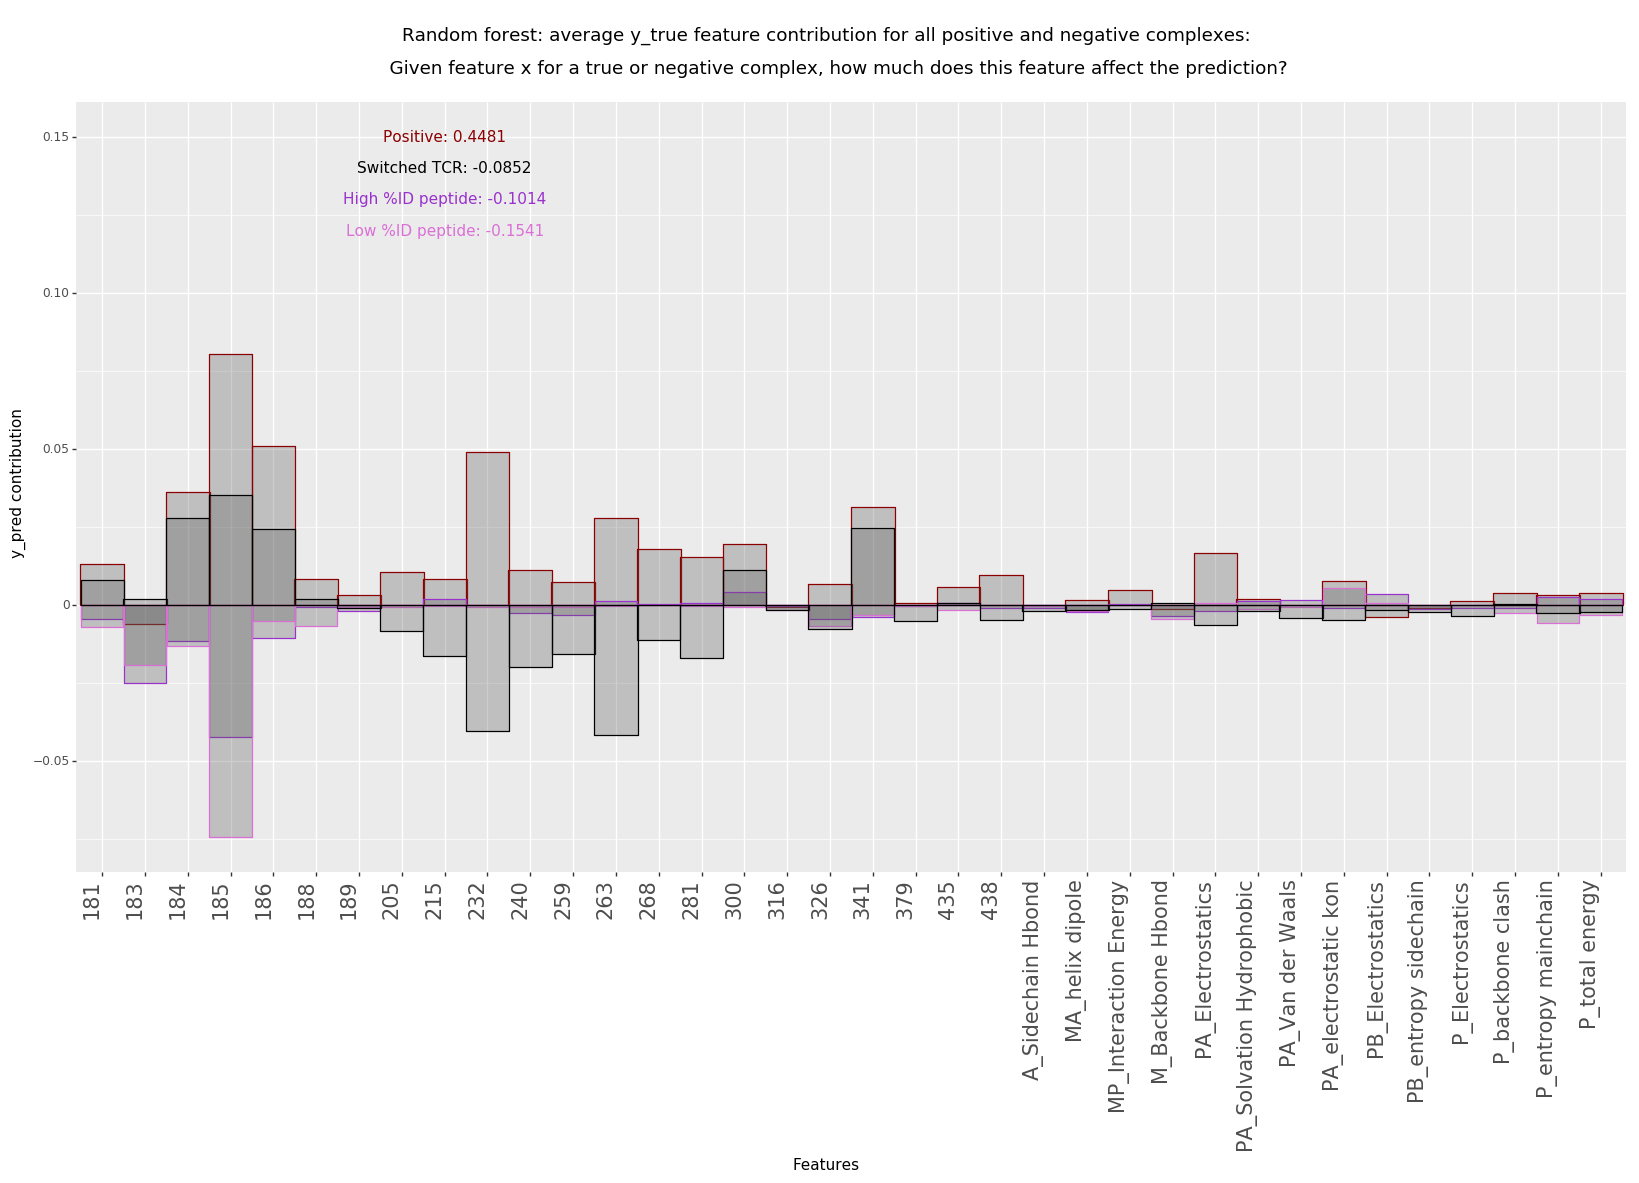

<ggplot: (8772891624014)>

In [2008]:
df = df
(ggplot(df, aes(df.index, "Positive"))
 #Plot values
    + geom_col(mapping = aes(df.index, "Positive"), color = "darkred", alpha = 0.3, width = 1.02)
    + geom_col(mapping = aes(df.index, "High ID"), color = "darkorchid", alpha = 0.3, width = 1.0)
    + geom_col(mapping = aes(df.index, "Low ID"), color = "orchid", alpha = 0.3, width = 0.99)
    + geom_col(mapping = aes(df.index, "TCR switch"), color = "black", alpha = 0.3, width = 1.01)
 
 #Colors
    + annotate("text", x = "215", y = 0.15, label = "Positive: " + pos, color = "darkred")
    + annotate("text", x = "215", y = 0.13, label = "High %ID peptide: " + high, color = "darkorchid")
    + annotate("text", x = "215", y = 0.12, label = "Low %ID peptide: " + low, color = "orchid")
    + annotate("text", x = "215", y = 0.14, label = "Switched TCR: " + switch, color = "black")


#    + annotate("text", x = "215", y = 0.11, label = "Some text", color = "red")
    + theme(figure_size =(20,10))
    + theme(axis_text_x=element_text(rotation=90, hjust=1, size = 15))
    + ggtitle("""\nRandom forest: average y_true feature contribution for all positive and negative complexes:\n
    Given feature x for a true or negative complex, how much does this feature affect the prediction?\n""")
    + xlab("Features")
    + ylab("y_pred contribution")
    + labs()
)

#### Old plot

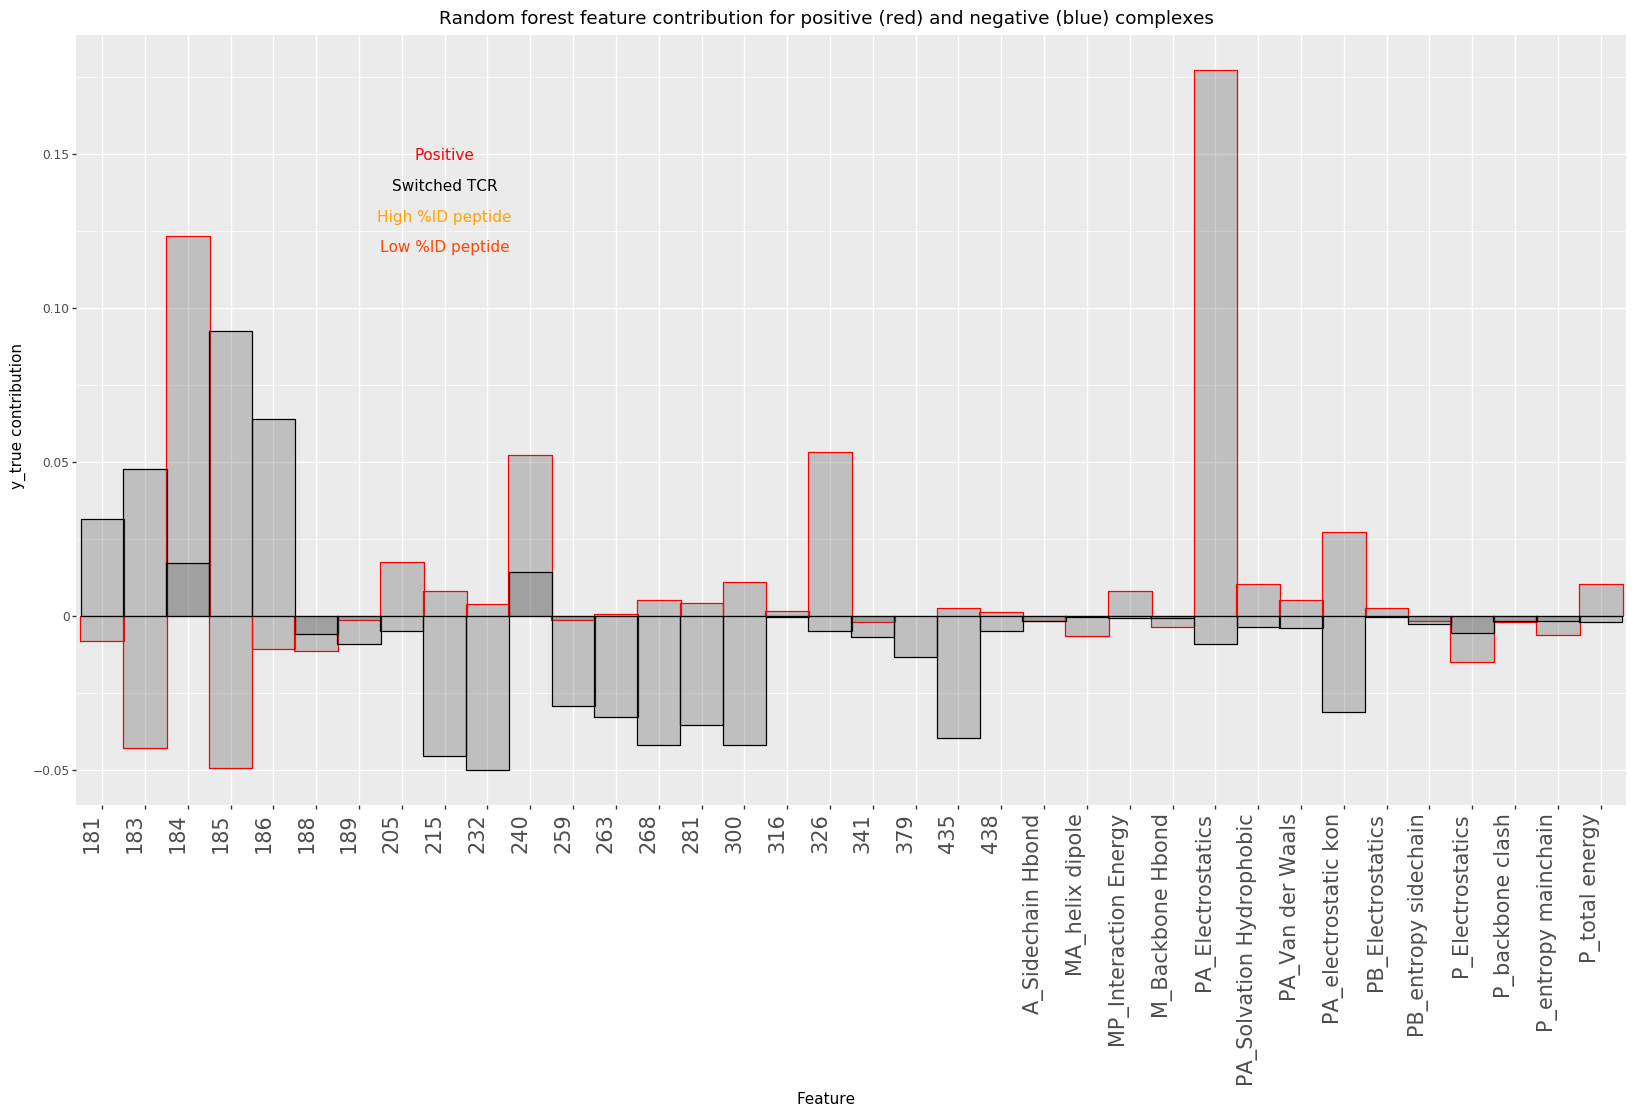

<ggplot: (8772865653838)>

In [1806]:
df = a
(ggplot(df, aes("feature", "4"))
 #Plot values
    + geom_col(mapping = aes("feature", "4"), color = "red", alpha = 0.3, width = 1.02)
    + geom_col(mapping = aes("feature", "3"), color = "black", alpha = 0.3, width = 1.01)
#    + geom_col(mapping = aes("feature", "0"), color = "orange", alpha = 0.3)
#    + geom_col(mapping = aes("feature", "1"), color = "orange", alpha = 0.3)
#    + geom_col(mapping = aes("feature", "2"), color = "orangered", alpha = 0.3)
 
 #Colors
    + annotate("text", x = "215", y = 0.15, label = "Positive", color = "red")
    + annotate("text", x = "215", y = 0.14, label = "Switched TCR", color = "black")
    + annotate("text", x = "215", y = 0.13, label = "High %ID peptide", color = "orange")
    + annotate("text", x = "215", y = 0.12, label = "Low %ID peptide", color = "orangered")

#    + annotate("text", x = "215", y = 0.11, label = "Some text", color = "red")
    + theme(figure_size =(20,10))
    + theme(axis_text_x=element_text(rotation=90, hjust=1, size = 15))
    + ggtitle("Random forest feature contribution for positive (red) and negative (blue) complexes")
    + xlab("Feature")
    + ylab("y_true contribution")
    + labs()
)

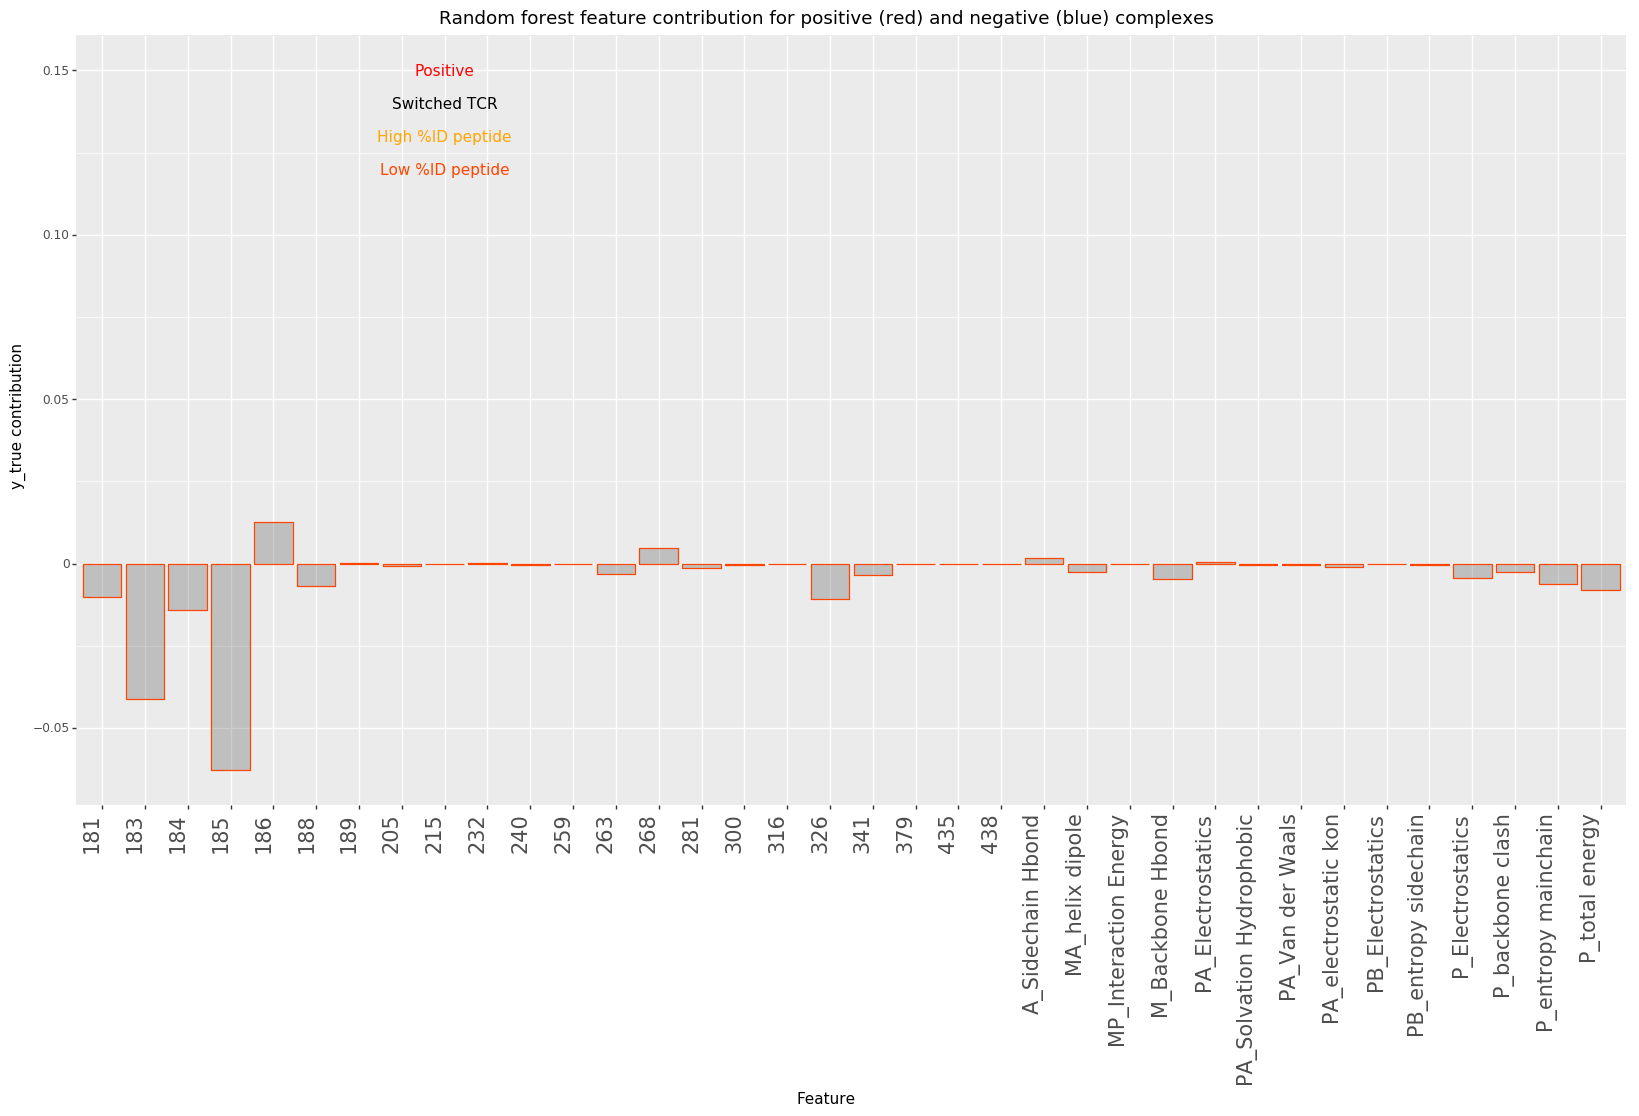

<ggplot: (8772891997097)>

In [1813]:
df = a
(ggplot(df, aes("feature", "4"))
 #Plot values
#    + geom_col(mapping = aes("feature", "4"), color = "red", alpha = 0.3, width = 1.02)
#    + geom_col(mapping = aes("feature", "3"), color = "black", alpha = 0.3, width = 1.01)
#    + geom_col(mapping = aes("feature", "0"), color = "orange", alpha = 0.3)
#    + geom_col(mapping = aes("feature", "1"), color = "orange", alpha = 0.3)
    + geom_col(mapping = aes("feature", "2"), color = "orangered", alpha = 0.3)
 
 #Colors
    + annotate("text", x = "215", y = 0.15, label = "Positive", color = "red")
    + annotate("text", x = "215", y = 0.14, label = "Switched TCR", color = "black")
    + annotate("text", x = "215", y = 0.13, label = "High %ID peptide", color = "orange")
    + annotate("text", x = "215", y = 0.12, label = "Low %ID peptide", color = "orangered")

#    + annotate("text", x = "215", y = 0.11, label = "Some text", color = "red")
    + theme(figure_size =(20,10))
    + theme(axis_text_x=element_text(rotation=90, hjust=1, size = 15))
    + ggtitle("Random forest feature contribution for positive (red) and negative (blue) complexes")
    + xlab("Feature")
    + ylab("y_true contribution")
    + labs()
)

In [1524]:
contributions[0].sum()

0.8083219489981784

In [676]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 528 ms, sys: 64.1 ms, total: 592 ms
Wall time: 281 ms
1. rmse: x/y train 2. rmse x/y valid 3. score x/y train 4. score x/y valid
[0.03789569654434071, 0.19476715532056915, 0.9896601965206185, 0.7268734375000001, 0.9420212503161177]
